In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_absolute_error as mae, classification_report
from sklearn.preprocessing import PolynomialFeatures

import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import (KFold, cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)

In [2]:
data = pd.read_csv('clean_data_for_analysis.csv')


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Beds                    953 non-null    float64
 1   Baths                   953 non-null    float64
 2   SQFT                    953 non-null    float64
 3   Lot_Size                953 non-null    float64
 4   Has_Garage              953 non-null    object 
 5   New_Construction        953 non-null    object 
 6   Days_on_Market          953 non-null    int64  
 7   Property_Type           953 non-null    object 
 8   Asking_Price            953 non-null    float64
 9   Sold_Price              953 non-null    int64  
 10  Difference_in_Price     953 non-null    float64
 11  Stories                 953 non-null    int64  
 12  Condition               953 non-null    object 
 13  Parking_Spaces          953 non-null    int64  
 14  Central_Air             953 non-null    ob

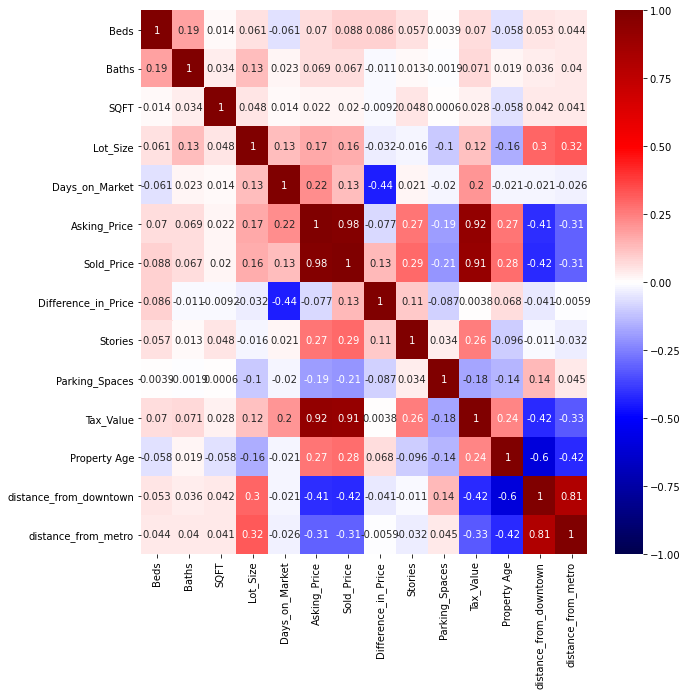

In [4]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

multilinarity among: 
-distance from downtown & distance from metro
-tax value and asking price

In [5]:
#high colinerarity 
data2 = data.drop(['distance_from_metro', 'Asking_Price','Difference_in_Price'], axis=1)

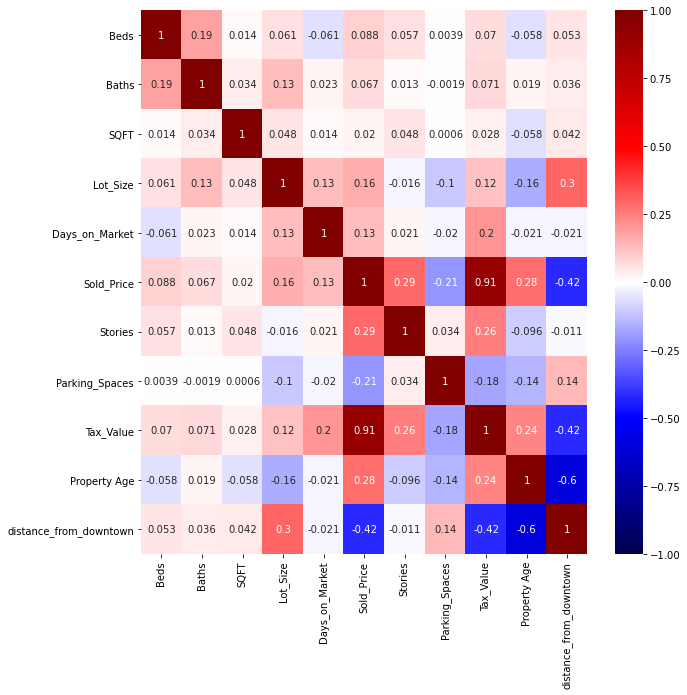

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data2.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [7]:
data2 = pd.get_dummies(data2, columns=['Has_Garage'])
data2 = pd.get_dummies(data2, columns=['New_Construction'])
data2 = pd.get_dummies(data2, columns=['Condition'])
data2 = pd.get_dummies(data2, columns=['Central_Air'])
data2 = pd.get_dummies(data2, columns=['Property_Type'])
data2 = pd.get_dummies(data2, columns=['regions'])



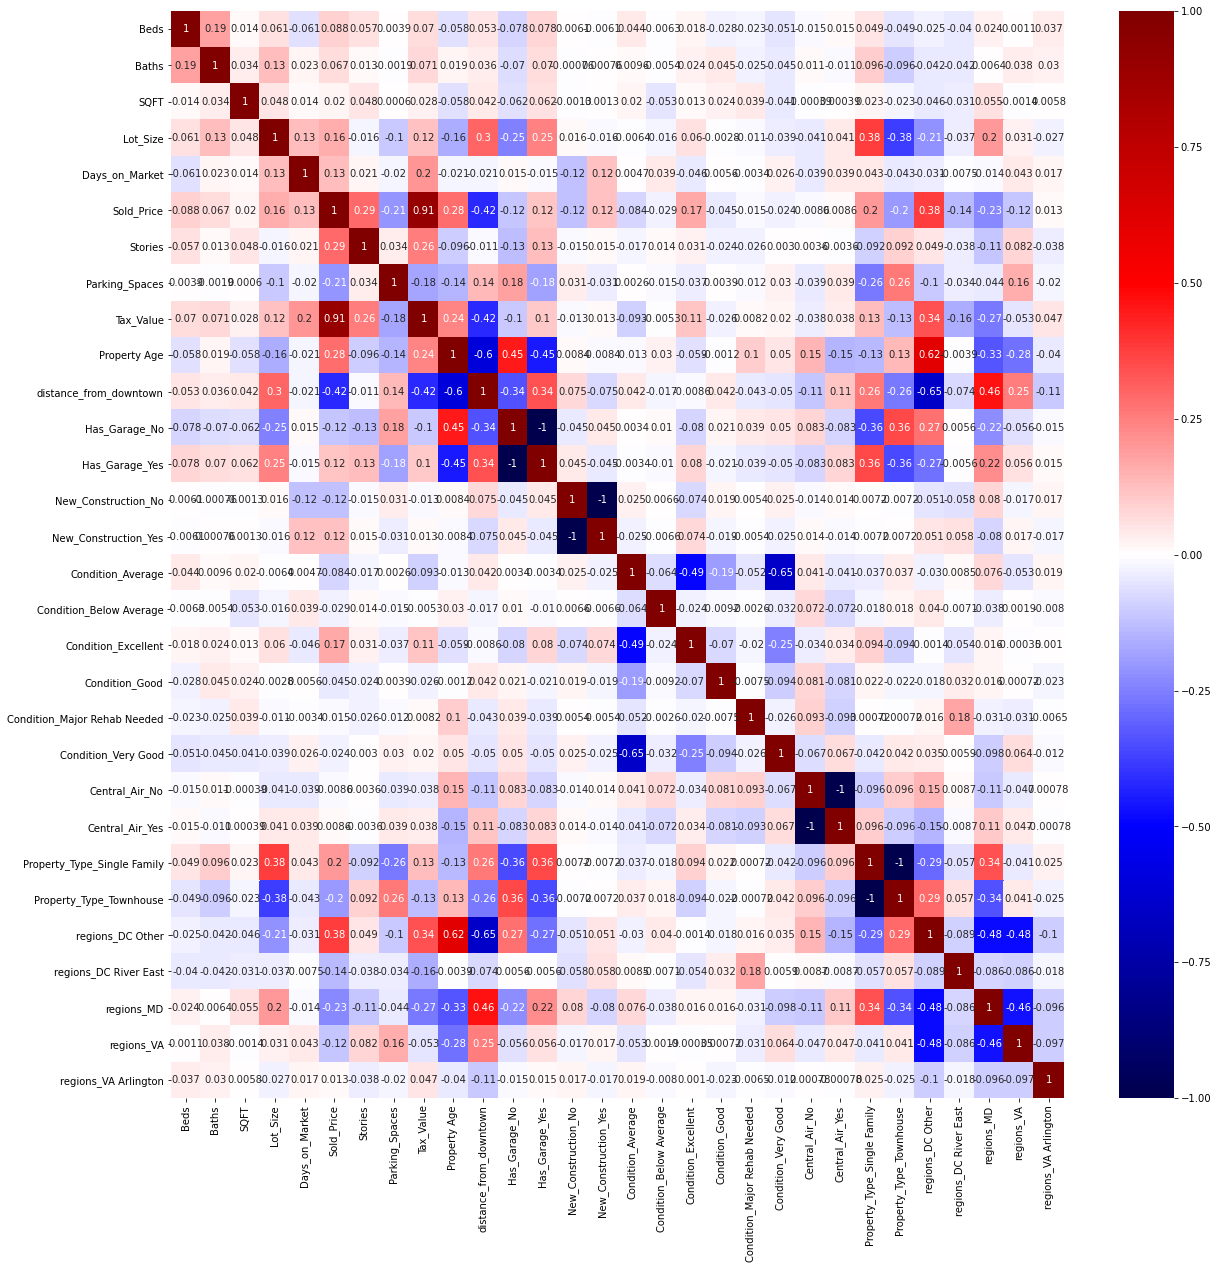

In [8]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data2.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [9]:
data2 = data2.drop(['Has_Garage_No', 'New_Construction_No'], axis=1)

In [10]:
data2.corr()['Sold_Price'].sort_values(ascending=False).head(50)

Sold_Price                      1.000000
Tax_Value                       0.912470
regions_DC Other                0.376548
Stories                         0.291818
Property Age                    0.281668
Property_Type_Single Family     0.198439
Condition_Excellent             0.169953
Lot_Size                        0.162505
Days_on_Market                  0.129437
New_Construction_Yes            0.123193
Has_Garage_Yes                  0.116149
Beds                            0.087861
Baths                           0.066543
SQFT                            0.020286
regions_VA Arlington            0.012739
Central_Air_Yes                 0.008597
Central_Air_No                 -0.008597
Condition_Major Rehab Needed   -0.015209
Condition_Very Good            -0.023821
Condition_Below Average        -0.028756
Condition_Good                 -0.045436
Condition_Average              -0.084189
regions_VA                     -0.115671
regions_DC River East          -0.140042
Property_Type_To

In [11]:
#drop features less than .1
features_for_analysis = data2.drop(['Beds','Baths','SQFT','Condition_Major Rehab Needed','Central_Air_Yes','Central_Air_No','regions_VA Arlington','Condition_Below Average','Condition_Very Good','Condition_Good','Condition_Average','New_Construction_Yes'], axis=1)

In [ ]:
#with tax value
#X, y = features_for_analysis.drop('Sold_Price',axis=1), features_for_analysis['Sold_Price']

In [12]:
#without tax value
X, y = features_for_analysis.drop(['Sold_Price', 'Tax_Value'],axis=1), features_for_analysis['Sold_Price']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [14]:
# Notice that we are splitting the X_train data into 5 Folds

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [15]:
lin_reg_est = LinearRegression()

scores = cross_val_score(lin_reg_est, X_train, y_train, cv=kfold)
print(scores)
print("Linear Reg Mean R Squared Score: ", np.mean(scores))

# Build the Model
lin_reg_est.fit(X_train, y_train)

print(lin_reg_est.score(X_test,y_test))

[0.47591503 0.54019544 0.51245176 0.42350926 0.52168313]
Linear Reg Mean R Squared Score:  0.49475092253725383
0.45497297027850736


Text(0, 0.5, 'Predicted Data')

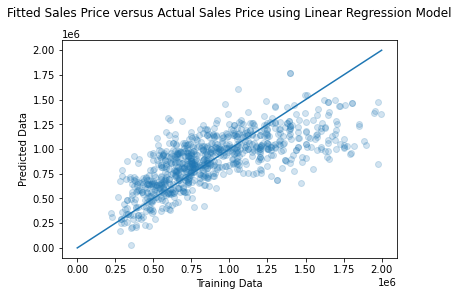

In [16]:
# Fitted vs. Actual
y_train_pred = lin_reg_est.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.2)
plt.plot([0, 2000000], [0, 2000000])
#plt.set_title("Fitted Sales Price versus Actual Sales Price using Lasso Model")

plt.title("Fitted Sales Price versus Actual Sales Price using Linear Regression Model", y=1.08)
plt.xlabel("Training Data")
plt.ylabel("Predicted Data")

In [17]:
# Run the cross validation, find the best alpha, 
#refit the model on all the data with that alpha

# use grid search to find alpha
alpha = np.logspace(-4, 2, 100)
param_grid = dict(alpha=alpha)
grid = GridSearchCV(Lasso(), param_grid=param_grid, 
                    scoring='neg_mean_absolute_error', cv = kfold)
grid_result = grid.fit(X_train, y_train)


print('Best Score: ', grid_result.best_score_)
print('Best Param: ', grid_result.best_params_)


Best Score:  -200956.21021002397
Best Param:  {'alpha': 100.0}


In [18]:
lr_model_lasso = LassoCV(alphas= [100.0], cv = kfold)
lr_model_lasso.fit(X_train, y_train)
scores = cross_val_score(lr_model_lasso, X_train, y_train, cv=kfold)
print(scores)
print("Lasso Mean R Squared Score: ", np.mean(scores))

print('Lasso R Squared Score test: ', lr_model_lasso.score(X_test, y_test))



[0.47603895 0.54006389 0.51277427 0.42363425 0.52214674]
Lasso Mean R Squared Score:  0.49493161856675094
Lasso R Squared Score test:  0.454489953743484


In [19]:
y_train_pred = lr_model_lasso.predict(X_train)
print('Lasso MAE: ',mae(y_train, y_train_pred))

Lasso MAE:  197647.34271504942


In [20]:
coeff = list(zip(lr_model_lasso.coef_, X_train.columns))
coeff_df = pd.DataFrame (coeff, columns = ['coef', 'feature'])
coeff_df = coeff_df.sort_values(by=['coef'], ascending=False)
coeff_df

coef                      feature
8   2.031737e+05  Property_Type_Single Family
10  1.704450e+05             regions_DC Other
2   1.646185e+05                      Stories
6   1.223473e+05               Has_Garage_Yes
7   1.102843e+05          Condition_Excellent
13  6.152801e+04                   regions_VA
1   2.032972e+03               Days_on_Market
4   8.053991e+02                 Property Age
0   3.911428e+00                     Lot_Size
9  -4.903412e-09      Property_Type_Townhouse
3  -1.921562e+03               Parking_Spaces
12 -6.499328e+03                   regions_MD
5  -2.644290e+04       distance_from_downtown
11 -3.026332e+05        regions_DC River East

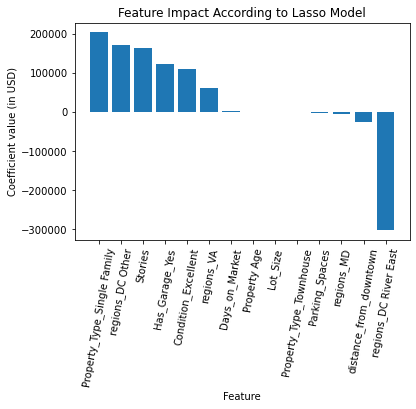

In [21]:
x1 = coeff_df['feature']
y1 = coeff_df['coef']


#Final_DF_by_income.plot(x="STATION", y=["Average Income"], kind="bar")

plt.bar(x1,y1)
plt.xticks(rotation=80)
plt.title('Feature Impact According to Lasso Model')
plt.ylabel('Coefficient value (in USD)');
plt.xlabel('Feature');


In [22]:
from sklearn.linear_model import lars_path


In [23]:
x_array = np.array(X_train)
y_array = np.array(y_train)

In [24]:
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(x_array, y_array, 
                             method='lasso')

Computing regularization path using the LARS ...


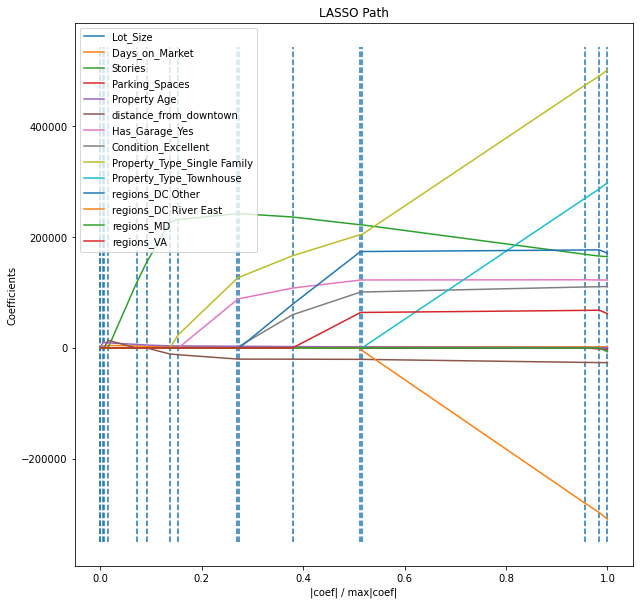

In [25]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

In [26]:
X_train

Lot_Size  Days_on_Market  Stories  Parking_Spaces  Property Age  \
72     8515.0               3        3               0            34   
543   11502.0              35        2               0            32   
44        0.0              38        3               0           131   
948    6100.0              20        3               0            90   
927    9015.0               5        3               0            84   
..        ...             ...      ...             ...           ...   
106    5689.0               8        3               0            72   
270    1517.0               8        3               2            36   
860    1341.0               6        3               0            19   
435    9181.0               1        2               0            60   
102    6431.0               5        2               0            16   

     distance_from_downtown  Has_Garage_Yes  Condition_Excellent  \
72                16.562696               1                    0   
543               15.825190               1                    0   
44                 0.784913               1                    1   
948                5.147708               1                    0   
927                4.893670               1                    0   
..                      ...             ...                  ...   
106                8.808624               0                    0   
270               12.784514               0                    0   
860                8.003473               1                    0   
435               11.600268               0                    0   
102               14.818334               1                    1   

     Property_Type_Single Family  Property_Type_Townhouse  regions_DC Other  \
72                             1                        0                 0   
543                            1                        0                 0   
44                             0                        1                 1   
948                            1                        0                 0   
927                            1                        0                 0   
..                           ...                      ...               ...   
106                            1                        0                 0   
270                            0                        1                 0   
860                            0                        1                 0   
435                            1                        0                 0   
102                            1                        0                 0   

     regions_DC River East  regions_MD  regions_VA  
72                       0           1           0  
543                      0           1           0  
44                       0           0           0  
948                      0           0           1  
927                      0           0           1  
..                     ...         ...         ...  
106                      0           1           0  
270                      0           1           0  
860                      0           0           1  
435                      0           1           0  
102                      0           1           0  

[857 rows x 14 columns]

Text(0, 0.5, 'Predicted Data')

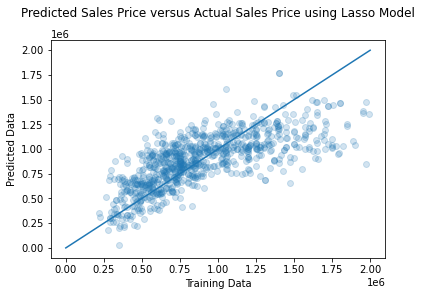

In [27]:
# Fitted vs. Actual
y_train_pred = lr_model_lasso.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.2)
plt.plot([0, 2000000], [0, 2000000])
#plt.set_title("Fitted Sales Price versus Actual Sales Price using Lasso Model")

plt.title("Predicted Sales Price versus Actual Sales Price using Lasso Model", y=1.08)
plt.xlabel("Training Data")
plt.ylabel("Predicted Data")

Text(0.5, 1.0, 'Residuals vs. Predictions')

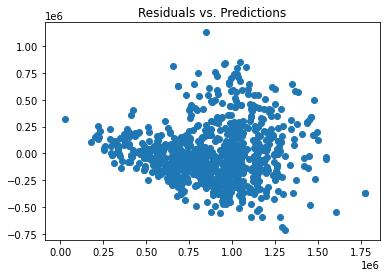

In [28]:
# Plot Residuals vs. predicted

lr_model_lasso_residuals = y_train - y_train_pred

plt.scatter(y_train_pred, lr_model_lasso_residuals)
plt.plot([0,400], [0, 0])
plt.title("Residuals vs. Predictions")

In [29]:
features_for_analysis['lr_model_lasso_residuals'] = lr_model_lasso_residuals

In [30]:
mask = features_for_analysis['lr_model_lasso_residuals'] < abs(100)
low_residuals = features_for_analysis[mask]


In [31]:
low_residuals = low_residuals.sort_values(by='lr_model_lasso_residuals', ascending = False)
low_residuals

Lot_Size  Days_on_Market  Sold_Price  Stories  Parking_Spaces  Tax_Value  \
262    8559.0               7      726000        3               0     631900   
483    1323.0              61     1150000        3               0    1034000   
697    1442.0              14     1015000        3               0     842830   
894    8617.0              23      965000        2               0     709184   
382   21931.0              20      812000        3               0     765440   
..        ...             ...         ...      ...             ...        ...   
600    5005.0               6      586000        3               0     456390   
442    1188.0              59      522500        3               0     504110   
473    4600.0               7      690000        3               0     459200   
305    3928.0              14      610000        3               0     493210   
615    6000.0               8      597000        3               0     517200   

     Property Age  distance_from_downtown  Has_Garage_Yes  \
262             8               12.016809               0   
483            95                0.690340               0   
697           121                2.974187               0   
894            45                6.259395               1   
382            26               19.390095               1   
..            ...                     ...             ...   
600           106                4.057219               0   
442           105                2.248824               0   
473            84                3.604904               0   
305            93                4.309751               1   
615           112                4.093392               1   

     Condition_Excellent  Property_Type_Single Family  \
262                    0                            1   
483                    0                            0   
697                    0                            0   
894                    0                            1   
382                    0                            1   
..                   ...                          ...   
600                    0                            1   
442                    0                            0   
473                    1                            1   
305                    0                            1   
615                    0                            1   

     Property_Type_Townhouse  regions_DC Other  regions_DC River East  \
262                        0                 0                      0   
483                        1                 1                      0   
697                        1                 1                      0   
894                        0                 0                      0   
382                        0                 0                      0   
..                       ...               ...                    ...   
600                        0                 1                      0   
442                        1                 1                      0   
473                        0                 1                      0   
305                        0                 1                      0   
615                        0                 1                      0   

     regions_MD  regions_VA  lr_model_lasso_residuals  
262           1           0                 67.985962  
483           0           0               -754.403680  
697           0           0              -1219.012595  
894           0           1              -1485.056352  
382           0           1              -2565.049180  
..          ...         ...                       ...  
600           0           0            -590345.896630  
442           0           0            -590503.591832  
473           0           0            -591320.762930  
305           0           0            -683596.530750  
615           0           0            -713526.911551  

[475 rows x 17 columns]

In [32]:
px.scatter(features_for_analysis, x = features_for_analysis['lr_model_lasso_residuals'].index, y = features_for_analysis['lr_model_lasso_residuals'], title = 'Residual Errors for Lasso Model on DC Real Estate Data')

In [33]:
low_error = features_for_analysis['lr_model_lasso_residuals'] < 10000
low_error = features_for_analysis[low_error]
high_error = features_for_analysis['lr_model_lasso_residuals'] > 10000
high_error = features_for_analysis[high_error]

In [34]:
print(len(low_error))
print(len(high_error))
print((len(low_error))/(len(low_error)+len(high_error)))

491
366
0.572928821470245
